In [1]:
import numpy as np
import pandas as pd
from time import time

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [3]:
train_df = pd.read_csv('data/mercari/train.tsv', sep='\t')
test_df = pd.read_csv('data/mercari/test.tsv', sep='\t')

In [4]:
train_df.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [5]:
train_df.shape

(1482535, 8)

In [6]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [7]:
print('Train columns with null values:\n', train_df.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', test_df.isnull().sum())
print("-"*10)

train_df.describe(include = 'all')

Train columns with null values:
 train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64
----------
Test/Validation columns with null values:
 test_id                   0
name                      0
item_condition_id         0
category_name          3058
brand_name           295525
shipping                  0
item_description          0
dtype: int64
----------


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
count,1.482535e+06,1482535,1.482535e+06,1476208,849853,1.482535e+06,1.482535e+06,1482531
unique,NaN,1225273,NaN,1287,4809,NaN,NaN,1281426
top,NaN,Bundle,NaN,"Women/Athletic Apparel/Pants, Tights, Leggings",PINK,NaN,NaN,No description yet
freq,NaN,2232,NaN,60177,54088,NaN,NaN,82489
mean,7.412670e+05,NaN,1.907380e+00,NaN,NaN,2.673752e+01,4.472744e-01,NaN
std,4.279711e+05,NaN,9.031586e-01,NaN,NaN,3.858607e+01,4.972124e-01,NaN
min,0.000000e+00,NaN,1.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,NaN
25%,3.706335e+05,NaN,1.000000e+00,NaN,NaN,1.000000e+01,0.000000e+00,NaN
50%,7.412670e+05,NaN,2.000000e+00,NaN,NaN,1.700000e+01,0.000000e+00,NaN
75%,1.111900e+06,NaN,3.000000e+00,NaN,NaN,2.900000e+01,1.000000e+00,NaN


Calculate how much of the brand names are not there.

In [8]:
print(632682/train_df.shape[0])

0.4267568725190299


Around 50% is not there hence we should probably not consider this.

In [9]:
train_df = train_df.drop(['brand_name'], axis=1)
test_df = test_df.drop(['brand_name'], axis=1)

# categories

We need to check how many categories there are

In [10]:
# Merge the two dataframes
frames = [train_df, test_df]
combined_df = pd.concat(frames)

In [11]:
combined_cat_df = combined_df['category_name']
def split_cat(text):
    try: return text.split("/")
    except: pass

combined_cat_df = combined_cat_df.apply(lambda x: split_cat(x))

In [12]:
def no_of_cats(cat_list):
    try: return len(cat_list)
    except: return 0
    
no_of_cats = pd.DataFrame(combined_cat_df.apply(lambda x: no_of_cats(x)))

In [13]:
# no_of_cats['category_name'].max(axis=1)
index_whr_max_categories = no_of_cats['category_name'].argmax()
print(index_whr_max_categories)
max_num_of_categories = len(split_cat(combined_df.iloc[[index_whr_max_categories]]['category_name'].tolist()[0]))
print('there are a maximum of {} categories and this is happened in row:'.format(max_num_of_categories))
combined_df.iloc[[index_whr_max_categories]]

239
there are a maximum of 5 categories and this is happened in row:


,category_name,item_condition_id,item_description,name,price,shipping,test_id,train_id
239,Electronics/Computers & Tablets/iPad/Tablet/eB...,1,Zag invisible shield for IPad air,Zagg invisible shield for IPad air,10.0,1,NaN,239.0


In [14]:
# def split_cat(text, max_num_of_categories):
#     return_val = ["None"] * max_num_of_categories
#     try:
#         text_list = text.split("/") + return_val
#         return text_list[:max_num_of_categories]
#     except:
#         return return_val
    
def split_cat(text):
    try:
        text_list = text.split("/")
        return text_list
    except:
        return np.nan

Change the category name for train and test and total dataframes

In [15]:
# train_df['category_name'] = train_df['category_name'].apply(lambda x: split_cat(x, max_num_of_categories))
# test_df['category_name'] = test_df['category_name'].apply(lambda x: split_cat(x, max_num_of_categories))
# combined_df['category_name'] = combined_df['category_name'].apply(lambda x: split_cat(x, max_num_of_categories))

train_df['category_name'] = train_df['category_name'].apply(lambda x: split_cat(x))
test_df['category_name'] = test_df['category_name'].apply(lambda x: split_cat(x))
combined_df['category_name'] = combined_df['category_name'].apply(lambda x: split_cat(x))

In [16]:
train_df.head()

,train_id,name,item_condition_id,category_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,"[Men, Tops, T-shirts]",10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,"[Electronics, Computers & Tablets, Components ...",52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,"[Women, Tops & Blouses, Blouse]",10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,"[Home, Home Décor, Home Décor Accents]",35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,"[Women, Jewelry, Necklaces]",44.0,0,Complete with certificate of authenticity


now we know that there are 5 categories so we will try to find the unknown ones category per category. so we will make predictions based on the 5 categories

### Compiling a list of categories and classifying them as category1, category2 and so on

In [17]:
def resolve_item(item, index):
    try:
        return item[index]
    except:
        return ""
    
    
def resolve_null_value(item, null_value):
    if item == null_value:
        return np.nan
    else:
        return item

    
def replace_null_value(df, le, category_name, nullity=''):
    null_value = le.transform([nullity])[0]
    return df[category_name].apply(lambda x: resolve_null_value(x, null_value))


def label_encoding_transform(target_df, combined_df, max_num_of_categories):
    category_transforms = []
    for i in range(max_num_of_categories):
        combined_cat_list = [resolve_item(x, i) for x in combined_df['category_name'].tolist()]
        
        cat_le = LabelEncoder()
        cat_le.fit(combined_cat_list)
        
        category_name = 'category_{}'.format(i)
        
        target_df[category_name] = cat_le.transform(target_df['category_name'].apply(lambda x: resolve_item(x, i)))
        
        # replace null value
        target_df[category_name] = replace_null_value(target_df, cat_le, category_name)
        category_transforms.append(cat_le)
    return target_df, category_transforms

In [18]:
train_df, train_cat_transforms = label_encoding_transform(train_df, combined_df, max_num_of_categories)
train_df.head()

,train_id,name,item_condition_id,category_name,price,shipping,item_description,category_0,category_1,category_2,category_3,category_4
0,0,MLB Cincinnati Reds T Shirt Size XL,3,"[Men, Tops, T-shirts]",10.0,1,No description yet,6.0,103.0,774.0,NaN,NaN
1,1,Razer BlackWidow Chroma Keyboard,3,"[Electronics, Computers & Tablets, Components ...",52.0,0,This keyboard is in great condition and works ...,2.0,31.0,216.0,NaN,NaN
2,2,AVA-VIV Blouse,1,"[Women, Tops & Blouses, Blouse]",10.0,1,Adorable top with a hint of lace and a key hol...,10.0,104.0,98.0,NaN,NaN
3,3,Leather Horse Statues,1,"[Home, Home Décor, Home Décor Accents]",35.0,1,New with tags. Leather horses. Retail for [rm]...,4.0,56.0,411.0,NaN,NaN
4,4,24K GOLD plated rose,1,"[Women, Jewelry, Necklaces]",44.0,0,Complete with certificate of authenticity,10.0,59.0,543.0,NaN,NaN


In [19]:
test_df, test_cat_transforms = label_encoding_transform(test_df, combined_df, max_num_of_categories)
test_df.head()

,test_id,name,item_condition_id,category_name,shipping,item_description,category_0,category_1,category_2,category_3,category_4
0,0,"Breast cancer ""I fight like a girl"" ring",1,"[Women, Jewelry, Rings]",1,Size 7,10.0,59.0,667.0,NaN,NaN
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,"[Other, Office supplies, Shipping Supplies]",1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",7.0,72.0,701.0,NaN,NaN
2,2,Coach bag,1,"[Vintage & Collectibles, Bags and Purses, Hand...",1,Brand new coach bag. Bought for [rm] at a Coac...,9.0,8.0,383.0,NaN,NaN
3,3,Floral Kimono,2,"[Women, Sweaters, Cardigan]",0,-floral kimono -never worn -lightweight and pe...,10.0,97.0,167.0,NaN,NaN
4,4,Life after Death,3,"[Other, Books, Religion & Spirituality]",1,Rediscovering life after the loss of a loved o...,7.0,15.0,662.0,NaN,NaN


There are some null values in item description so will need to make fill them.

In [20]:
print('presently number of null values in train and test.')
print(train_df['item_description'].isnull().sum())
print(test_df['item_description'].isnull().sum())

presently number of null values in train and test.
4
0


In [21]:
train_df['item_description'] = train_df['item_description'].fillna("")
test_df['item_description'] = test_df['item_description'].fillna("")
print('Num of null values in item description is for training set is {}.'.format(train_df['item_description'].isnull().sum()))
print('Num of null values in item description is for test set is {}.'.format(test_df['item_description'].isnull().sum()))
print('Ideally this number should be 0.')

Num of null values in item description is for training set is 0.
Num of null values in item description is for test set is 0.
Ideally this number should be 0.


In [22]:
train_df[train_df.isnull().any(axis=1)].head()

,train_id,name,item_condition_id,category_name,price,shipping,item_description,category_0,category_1,category_2,category_3,category_4
0,0,MLB Cincinnati Reds T Shirt Size XL,3,"[Men, Tops, T-shirts]",10.0,1,No description yet,6.0,103.0,774.0,NaN,NaN
1,1,Razer BlackWidow Chroma Keyboard,3,"[Electronics, Computers & Tablets, Components ...",52.0,0,This keyboard is in great condition and works ...,2.0,31.0,216.0,NaN,NaN
2,2,AVA-VIV Blouse,1,"[Women, Tops & Blouses, Blouse]",10.0,1,Adorable top with a hint of lace and a key hol...,10.0,104.0,98.0,NaN,NaN
3,3,Leather Horse Statues,1,"[Home, Home Décor, Home Décor Accents]",35.0,1,New with tags. Leather horses. Retail for [rm]...,4.0,56.0,411.0,NaN,NaN
4,4,24K GOLD plated rose,1,"[Women, Jewelry, Necklaces]",44.0,0,Complete with certificate of authenticity,10.0,59.0,543.0,NaN,NaN


In [23]:
test_df[test_df.isnull().any(axis=1)].head()

,test_id,name,item_condition_id,category_name,shipping,item_description,category_0,category_1,category_2,category_3,category_4
0,0,"Breast cancer ""I fight like a girl"" ring",1,"[Women, Jewelry, Rings]",1,Size 7,10.0,59.0,667.0,NaN,NaN
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,"[Other, Office supplies, Shipping Supplies]",1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",7.0,72.0,701.0,NaN,NaN
2,2,Coach bag,1,"[Vintage & Collectibles, Bags and Purses, Hand...",1,Brand new coach bag. Bought for [rm] at a Coac...,9.0,8.0,383.0,NaN,NaN
3,3,Floral Kimono,2,"[Women, Sweaters, Cardigan]",0,-floral kimono -never worn -lightweight and pe...,10.0,97.0,167.0,NaN,NaN
4,4,Life after Death,3,"[Other, Books, Religion & Spirituality]",1,Rediscovering life after the loss of a loved o...,7.0,15.0,662.0,NaN,NaN


In [24]:
value_list = ['iPhone']
train_df[train_df.name.isin(value_list)].head()

,train_id,name,item_condition_id,category_name,price,shipping,item_description,category_0,category_1,category_2,category_3,category_4
161166,161166,iPhone,1,"[Electronics, Cell Phones & Accessories, Cell ...",4.0,1,Luxury 360° Hybrid Acrylic Hard Case Original ...,2.0,24.0,178.0,NaN,NaN
331692,331692,iPhone,2,"[Electronics, Cell Phones & Accessories, Cell ...",76.0,0,iCloud lock!!! Screen protector no scratches! ...,2.0,24.0,179.0,NaN,NaN
502203,502203,iPhone,3,"[Electronics, Cell Phones & Accessories, Cell ...",26.0,1,No description yet,2.0,24.0,179.0,NaN,NaN
901734,901734,iPhone,1,"[Electronics, Cell Phones & Accessories, Cell ...",17.0,1,Apple iPhone headphones for iPhones compatible...,2.0,24.0,179.0,NaN,NaN
968525,968525,iPhone,2,"[Electronics, Cell Phones & Accessories, Cell ...",19.0,0,Two iPhone 4s they are locked so they are to b...,2.0,24.0,179.0,NaN,NaN


For the missing category names we should try to find some unsupervised learning so that some amount filling of the data should be present.

# Running NLP on the categories

We will first try to classify the documents and see if we can get some meaningful classification based on that.

Idea is to use only the name to predict the category name

So we will drop all the remaining columns

In [25]:
print(train_df.columns.tolist())

['train_id', 'name', 'item_condition_id', 'category_name', 'price', 'shipping', 'item_description', 'category_0', 'category_1', 'category_2', 'category_3', 'category_4']


In [26]:
from copy import deepcopy
category_df = deepcopy(train_df)

In [27]:
category_df = category_df.drop(['train_id', 'item_condition_id', 'price', 'shipping'], axis=1)

In [28]:
category_df.sample(2)

,name,category_name,item_description,category_0,category_1,category_2,category_3,category_4
656268,The North Face Hoodie,"[Women, Sweaters, Hooded]","Like new, I think I wore it twice but it's jus...",10.0,97.0,417.0,NaN,NaN
1253718,Amazon Fire Stick with Alexa,"[Electronics, TV, Audio & Surveillance, Televi...",No description yet,2.0,100.0,788.0,NaN,NaN


In [29]:
predict_category_df = category_df[pd.isnull(category_df['category_name'])]
train_test_categry_df = category_df[pd.notnull(category_df['category_name'])]
train_categry_df, test_categry_df = train_test_split(train_test_categry_df, test_size=0.2, random_state=42)
print('separated into predict, train and test')
print(category_df.shape, predict_category_df.shape, train_categry_df.shape, test_categry_df.shape)
print(predict_category_df.shape[0] + train_categry_df.shape[0] + test_categry_df.shape[0])

separated into predict, train and test
(1482535, 8) (6327, 8) (1180966, 8) (295242, 8)
1482535


In [30]:
def predict_train_test(category_df, category_name):
    predict_category_df = category_df[pd.isnull(category_df[category_name])]
    train_test_categry_df = category_df[pd.notnull(category_df[category_name])]
    train_categry_df, test_categry_df = train_test_split(train_test_categry_df, test_size=0.2, random_state=42)
    return dict(predict_category_df=predict_category_df, 
                train_categry_df=train_categry_df, 
                test_categry_df=test_categry_df)

In [31]:
predict_train_test_dict = {}

In [32]:
predict_train_test_dict['category_0'] = predict_train_test(category_df, 'category_0')
predict_train_test_dict['category_1'] = predict_train_test(category_df, 'category_1')

In [33]:
# X_train_category_df = train_categry_df[['name', 'item_description']]
# y_train_category_df = train_categry_df[['category_0']]
# X_test_category_df = test_categry_df[['name', 'item_description']]
# y_test_category_df = test_categry_df[['category_0']]
# print('separate to x and y')
# print(X_train_category_df.shape, y_train_category_df.shape, X_test_category_df.shape, y_test_category_df.shape)

In [34]:
X_train_category_df_list = [df['train_categry_df'][['name', 'item_description']] for cat, df in predict_train_test_dict.items()]
y_train_category_df_list = [df['train_categry_df'][[cat]] for cat, df in predict_train_test_dict.items()]
X_test_category_df_list = [df['test_categry_df'][['name', 'item_description']] for cat, df in predict_train_test_dict.items()]
y_test_category_df_list = [df['test_categry_df'][[cat]] for cat, df in predict_train_test_dict.items()]

In [35]:
print('separate to x and y')
print(X_train_category_df_list[0].shape, y_train_category_df_list[0].shape, X_test_category_df_list[0].shape, y_test_category_df_list[0].shape)
print(X_train_category_df_list[1].shape, y_train_category_df_list[1].shape, X_test_category_df_list[1].shape, y_test_category_df_list[1].shape)

separate to x and y
(1180966, 2) (1180966, 1) (295242, 2) (295242, 1)
(1180966, 2) (1180966, 1) (295242, 2) (295242, 1)


In [36]:
y_train_category_df_list[0].head()

,category_0
943192,5.0
397137,10.0
697816,5.0
533679,10.0
301180,8.0


In [37]:
X_train_category_df_list[0].head()

,name,item_description
943192,Nike foams infant shoes,"Size: 2c Color: platinum, wolf grey in excelle..."
397137,Adidas athletic shoes,Barely worn! Looks new
697816,Free ship 3 small bun squishy,Free ship 3 small bun
533679,Blue and Yellow Oversized Blanket Scarf,Brand New! Free Shipping! Cobalt Blue Blanket ...
301180,Fantasy Football trophie,Gently used & loved trophy Looking for a new h...


In [38]:
number_of_cats = len(X_train_category_df_list)
for i in range(number_of_cats):
    X_train_category_df_list[i]['total_text'] = (
        X_train_category_df_list[i]['name'] 
        + " " 
        +  X_train_category_df_list[i]['item_description']
    )
    
    X_test_category_df_list[i]['total_text'] = (
        X_test_category_df_list[i]['name'] 
        + " " +  X_test_category_df_list[i]['item_description']
    )


X_train_category_df_list[0].head()

/home/joydeep/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/joydeep/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,name,item_description,total_text
943192,Nike foams infant shoes,"Size: 2c Color: platinum, wolf grey in excelle...",Nike foams infant shoes Size: 2c Color: platin...
397137,Adidas athletic shoes,Barely worn! Looks new,Adidas athletic shoes Barely worn! Looks new
697816,Free ship 3 small bun squishy,Free ship 3 small bun,Free ship 3 small bun squishy Free ship 3 smal...
533679,Blue and Yellow Oversized Blanket Scarf,Brand New! Free Shipping! Cobalt Blue Blanket ...,Blue and Yellow Oversized Blanket Scarf Brand ...
301180,Fantasy Football trophie,Gently used & loved trophy Looking for a new h...,Fantasy Football trophie Gently used & loved t...


In [39]:
vectorizers = []
x_trains = []

print('Extracting features from the training data using a sparse vectorizer')
t0 = time()
for i in range(number_of_cats):
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
    x_train = vectorizer.fit_transform(X_train_category_df_list[i]['total_text'])
    vectorizers.append(vectorizer)
    x_trains.append(x_train)
duration = time() - t0
print("done in %fs" % (duration))    
# print("n_samples: %d, n_features: %d" % x_train.shape)
print()

Extracting features from the training data using a sparse vectorizer
done in 87.882099s



In [40]:
x_tests = []

print('Extracting features from the testing data using a sparse vectorizer')
t0 = time()
for i in range(number_of_cats):
    x_test = vectorizers[i].transform(X_test_category_df_list[i]['total_text'])
    x_tests.append(x_test)
duration = time() - t0
print("done in %fs" % (duration))    
print("n_samples: %d, n_features: %d" % x_train.shape)
print()

Extracting features from the testing data using a sparse vectorizer
done in 22.276248s
n_samples: 1180966, n_features: 180315



In [41]:
# feature_names = vectorizer.get_feature_names()

In [42]:
# #############################################################################  
# Benchmark classifiers                                                          
def fit_and_benchmark(clf, X_train, y_train, X_test, y_test, target_names):                                                              
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
                                                                                 
    if hasattr(clf, 'coef_'):                                                    
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))
                                                                                 
        if feature_names is not None:                       
            print("top 10 keywords per class:")                                  
            for i, label in enumerate(target_names):                             
                top10 = np.argsort(clf.coef_[i])[-10:]
        print()
                                                                                 
    print("classification report:")
    print(metrics.classification_report(y_test, pred, target_names=target_names))          
                                                                                 
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))                            
                                                                                 
    print()                                                                      
    clf_descr = str(clf).split('(')[0]                                           
    print(clf_descr, score, train_time, test_time)
    return clf

In [43]:
# clf = VotingClassifier(estimators=[
#     ('rc', RidgeClassifier(tol=1e-2)),
#     ('perc', Perceptron(n_iter=50)),
#     ('pa', PassiveAggressiveClassifier(n_iter=50)),
#     ('knn', KNeighborsClassifier(n_neighbors=len(cat1_le.classes_))),
#     ('rfc', RandomForestClassifier(n_estimators=100)),
#     ('sgd', SGDClassifier(alpha=.0001, n_iter=50, penalty="elasticnet")),
#     ('SVC_with_L1', Pipeline([
#         ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3))),
#         ('classification', LinearSVC(penalty="l2"))]))
# ])
# clf = VotingClassifier(estimators=[
#     ('rc', RidgeClassifier(tol=1e-2)),
#     ('perc', Perceptron(n_iter=50)),
#     ('pa', PassiveAggressiveClassifier(n_iter=50))
# ])
clf = VotingClassifier(estimators=[
    ('rc', RidgeClassifier(tol=1e-2))
])

In [44]:
clfs = []
t0 = time()
for i in range(number_of_cats):
    clf = fit_and_benchmark(clf, x_trains[i], y_train_category_df_list[i], x_tests[i], y_test_category_df_list[i], train_cat_transforms[i].classes_)
    clfs.append(clf)
classification_time = time() - t0
print("classifiction time:  %0.3fs" % classification_time)

________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('rc', RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.01))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)


/home/joydeep/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/joydeep/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train time: 223.312s
test time:  11.201s
accuracy:   0.866
classification report:


/home/joydeep/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 10, does not match size of target_names, 11
  .format(len(labels), len(target_names))


                        precision    recall  f1-score   support

                             0.95      0.95      0.95     41574
                Beauty       0.93      0.95      0.94     24394
           Electronics       0.62      0.30      0.41      6152
              Handmade       0.81      0.78      0.79     13691
                  Home       0.85      0.81      0.83     34146
                  Kids       0.83      0.64      0.72     18931
                   Men       0.78      0.60      0.68      9163
                 Other       0.73      0.49      0.59      5006
     Sports & Outdoors       0.66      0.39      0.49      9181
Vintage & Collectibles       0.86      0.97      0.91    133004

           avg / total       0.86      0.87      0.86    295242

confusion matrix:
[[ 39539     29     23    282    109     53    241     16     12   1270]
 [    68  23184     36     59    228     43    109     69     42    556]
 [   114     50   1876    291    549     87    250     85    143 

/home/joydeep/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/joydeep/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



train time: 2009.491s
test time:  4.155s
accuracy:   0.764
classification report:


/home/joydeep/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 113, does not match size of target_names, 114
  .format(len(labels), len(target_names))
/home/joydeep/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                           precision    recall  f1-score   support

                                0.54      0.45      0.49      1687
              Accessories       0.57      0.21      0.31      1250
                  Antique       0.54      0.06      0.11       573
                  Apparel       0.60      0.21      0.31       120
                      Art       0.59      0.47      0.52       245
                  Artwork       0.74      0.83      0.78     26906
         Athletic Apparel       0.68      0.42      0.52       501
               Automotive       0.35      0.03      0.05      1294
          Bags and Purses       0.67      0.58      0.62       264
                     Bath       0.67      0.57      0.61      1547
              Bath & Body       0.68      0.31      0.42       155
      Bathing & Skin Care       0.70      0.82      0.76       846
                  Bedding       1.00      0.07      0.12        15
    Blazers & Sport Coats       0.71      0.54      0.61     

### fill the category name for the missing values and build the matrix

In [45]:
train_df['total_text'] = train_df['name'] + " " +  train_df['item_description']
train_df.head()

,train_id,name,item_condition_id,category_name,price,shipping,item_description,category_0,category_1,category_2,category_3,category_4,total_text
0,0,MLB Cincinnati Reds T Shirt Size XL,3,"[Men, Tops, T-shirts]",10.0,1,No description yet,6.0,103.0,774.0,NaN,NaN,MLB Cincinnati Reds T Shirt Size XL No descrip...
1,1,Razer BlackWidow Chroma Keyboard,3,"[Electronics, Computers & Tablets, Components ...",52.0,0,This keyboard is in great condition and works ...,2.0,31.0,216.0,NaN,NaN,Razer BlackWidow Chroma Keyboard This keyboard...
2,2,AVA-VIV Blouse,1,"[Women, Tops & Blouses, Blouse]",10.0,1,Adorable top with a hint of lace and a key hol...,10.0,104.0,98.0,NaN,NaN,AVA-VIV Blouse Adorable top with a hint of lac...
3,3,Leather Horse Statues,1,"[Home, Home Décor, Home Décor Accents]",35.0,1,New with tags. Leather horses. Retail for [rm]...,4.0,56.0,411.0,NaN,NaN,Leather Horse Statues New with tags. Leather h...
4,4,24K GOLD plated rose,1,"[Women, Jewelry, Necklaces]",44.0,0,Complete with certificate of authenticity,10.0,59.0,543.0,NaN,NaN,24K GOLD plated rose Complete with certificate...


In [46]:
test_df['total_text'] = test_df['name'] + " " +  test_df['item_description']
test_df.head()

,test_id,name,item_condition_id,category_name,shipping,item_description,category_0,category_1,category_2,category_3,category_4,total_text
0,0,"Breast cancer ""I fight like a girl"" ring",1,"[Women, Jewelry, Rings]",1,Size 7,10.0,59.0,667.0,NaN,NaN,"Breast cancer ""I fight like a girl"" ring Size 7"
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,"[Other, Office supplies, Shipping Supplies]",1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",7.0,72.0,701.0,NaN,NaN,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers 25 pc..."
2,2,Coach bag,1,"[Vintage & Collectibles, Bags and Purses, Hand...",1,Brand new coach bag. Bought for [rm] at a Coac...,9.0,8.0,383.0,NaN,NaN,Coach bag Brand new coach bag. Bought for [rm]...
3,3,Floral Kimono,2,"[Women, Sweaters, Cardigan]",0,-floral kimono -never worn -lightweight and pe...,10.0,97.0,167.0,NaN,NaN,Floral Kimono -floral kimono -never worn -ligh...
4,4,Life after Death,3,"[Other, Books, Religion & Spirituality]",1,Rediscovering life after the loss of a loved o...,7.0,15.0,662.0,NaN,NaN,Life after Death Rediscovering life after the ...


In [47]:
train_df_with_no_cat = train_df[train_df['category_name'].isnull()]
train_df_with_no_cat.head()

,train_id,name,item_condition_id,category_name,price,shipping,item_description,category_0,category_1,category_2,category_3,category_4,total_text
122,122,Bundle,3,NaN,59.0,0,Sizes and info of clothes can be found on thei...,NaN,NaN,NaN,NaN,NaN,Bundle Sizes and info of clothes can be found ...
155,155,3 Nora Roberts Books,3,NaN,10.0,1,For aferg16.,NaN,NaN,NaN,NaN,NaN,3 Nora Roberts Books For aferg16.
258,258,ACER Laptop,5,NaN,14.0,0,"Powers on, no screen display, no external dama...",NaN,NaN,NaN,NaN,NaN,"ACER Laptop Powers on, no screen display, no e..."
984,984,AUTHENTIC BRWN MICHAEL KORS MAKEUP STAIN,4,NaN,18.0,0,No description yet,NaN,NaN,NaN,NaN,NaN,AUTHENTIC BRWN MICHAEL KORS MAKEUP STAIN No de...
1185,1185,Teenage Mutant Ninja Turtle Van/ Extras,3,NaN,9.0,0,"Teenage Mutant Ninja Turtle Van, April O'Neil ...",NaN,NaN,NaN,NaN,NaN,Teenage Mutant Ninja Turtle Van/ Extras Teenag...


In [48]:
test_df_with_no_cat = test_df[test_df['category_name'].isnull()]
test_df_with_no_cat.head()

,test_id,name,item_condition_id,category_name,shipping,item_description,category_0,category_1,category_2,category_3,category_4,total_text
217,217,Lularoe XS Carly Dress,3,NaN,0,XS Lularoe Carly Dress. Has peach tone color s...,NaN,NaN,NaN,NaN,NaN,Lularoe XS Carly Dress XS Lularoe Carly Dress....
555,555,Victoria's Secret VerySexy Touch Perfume,2,NaN,0,No description yet,NaN,NaN,NaN,NaN,NaN,Victoria's Secret VerySexy Touch Perfume No de...
702,702,Men's All Black Low Top Converse,3,NaN,0,"Men's Converse, size 11, all black. They have ...",NaN,NaN,NaN,NaN,NaN,Men's All Black Low Top Converse Men's Convers...
1110,1110,92 Polly Pocket Jewel Palace/Ice Kingdom,3,NaN,0,Set of 2. In good condition. Both are complete...,NaN,NaN,NaN,NaN,NaN,92 Polly Pocket Jewel Palace/Ice Kingdom Set o...
1476,1476,Bundle for Vanessa Wieseler,1,NaN,0,Avent Bottle Warmer Brand New Open Package [rm...,NaN,NaN,NaN,NaN,NaN,Bundle for Vanessa Wieseler Avent Bottle Warme...


In [49]:
def fill_and_transform_df(df):
    new_df = deepcopy(df)
    for index, row in df.iterrows():
        if pd.isnull(row['category_name']):
            new_df.loc[index]['category_name'] = vectorizer.transform([row['total_text']])
        else:
            new_df.loc[index]['category_name'] = row['category_name']
    return new_df

In [50]:
matrix_train_df = vectorizer.transform(train_df_with_no_cat['total_text'])
pred_train_df = clf.predict(matrix_train_df)
print(pred_train_df.shape, train_df_with_no_cat.shape)

(6327,) (6327, 13)


In [51]:
matrix_test_df = vectorizer.transform(test_df_with_no_cat['total_text'])
pred_test_df = clf.predict(matrix_test_df)
print(pred_test_df.shape, test_df_with_no_cat.shape)

(3058,) (3058, 12)


fill the category_names with the predicted values wherever they are not present. This will be used in further predictions using pytorch.

In [52]:
print(train_df.loc[122])
i = 0
for index, row in train_df_with_no_cat.iterrows():
    train_df.loc[train_df.train_id == index, ['category_0']] = pred_train_df[i]
    i += 1
print(train_df.loc[122])

train_id                                                           122
name                                                            Bundle
item_condition_id                                                    3
category_name                                                      NaN
price                                                               59
shipping                                                             0
item_description     Sizes and info of clothes can be found on thei...
category_0                                                         NaN
category_1                                                         NaN
category_2                                                         NaN
category_3                                                         NaN
category_4                                                         NaN
total_text           Bundle Sizes and info of clothes can be found ...
Name: 122, dtype: object
train_id                                            

In [53]:
i = 0
for index, row in test_df_with_no_cat.iterrows():
    test_df.loc[test_df.test_id == index, ['category_0']] = pred_test_df[i]
    i += 1

In [54]:
train_df[train_df['category_0'].isnull()]

,train_id,name,item_condition_id,category_name,price,shipping,item_description,category_0,category_1,category_2,category_3,category_4,total_text


### Now coming to the main part and the main price predictions

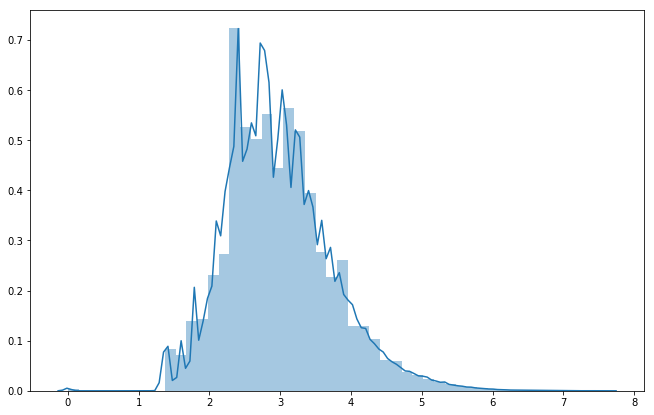

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.distplot(np.log(train_df['price'].values+1))

In [56]:
# vectorized error calc
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))
# Source: https://www.kaggle.com/jpopham91/rmlse-vectorized

In [57]:
print('lets see if there are some null values')
train_df.isnull().sum()

lets see if there are some null values


train_id                   0
name                       0
item_condition_id          0
category_name           6327
price                      0
shipping                   0
item_description           0
category_0                 0
category_1              6327
category_2              6327
category_3           1478146
category_4           1479476
total_text                 0
dtype: int64

In [58]:
#PROCESS CATEGORICAL DATA
#print("Handling categorical variables...")
def encode_text(column):
    le = LabelEncoder()
    le.fit(np.hstack([train_df[column], test_df[column]]))
    train_df[column+'_index'] = le.transform(train_df[column])
    test_df[column+'_index'] = le.transform(test_df[column])

In [59]:
train_df.columns.to_series().groupby(train_df.dtypes).groups

{dtype('int64'): Index(['train_id', 'item_condition_id', 'shipping'], dtype='object'),
 dtype('float64'): Index(['price', 'category_0', 'category_1', 'category_2', 'category_3',
        'category_4'],
       dtype='object'),
 dtype('O'): Index(['name', 'category_name', 'item_description', 'total_text'], dtype='object')}

In [60]:
train_df.select_dtypes(exclude=['float64', 'int64']).head()

,name,category_name,item_description,total_text
0,MLB Cincinnati Reds T Shirt Size XL,"[Men, Tops, T-shirts]",No description yet,MLB Cincinnati Reds T Shirt Size XL No descrip...
1,Razer BlackWidow Chroma Keyboard,"[Electronics, Computers & Tablets, Components ...",This keyboard is in great condition and works ...,Razer BlackWidow Chroma Keyboard This keyboard...
2,AVA-VIV Blouse,"[Women, Tops & Blouses, Blouse]",Adorable top with a hint of lace and a key hol...,AVA-VIV Blouse Adorable top with a hint of lac...
3,Leather Horse Statues,"[Home, Home Décor, Home Décor Accents]",New with tags. Leather horses. Retail for [rm]...,Leather Horse Statues New with tags. Leather h...
4,24K GOLD plated rose,"[Women, Jewelry, Necklaces]",Complete with certificate of authenticity,24K GOLD plated rose Complete with certificate...


In [61]:
train_df.head()

,train_id,name,item_condition_id,category_name,price,shipping,item_description,category_0,category_1,category_2,category_3,category_4,total_text
0,0,MLB Cincinnati Reds T Shirt Size XL,3,"[Men, Tops, T-shirts]",10.0,1,No description yet,6.0,103.0,774.0,NaN,NaN,MLB Cincinnati Reds T Shirt Size XL No descrip...
1,1,Razer BlackWidow Chroma Keyboard,3,"[Electronics, Computers & Tablets, Components ...",52.0,0,This keyboard is in great condition and works ...,2.0,31.0,216.0,NaN,NaN,Razer BlackWidow Chroma Keyboard This keyboard...
2,2,AVA-VIV Blouse,1,"[Women, Tops & Blouses, Blouse]",10.0,1,Adorable top with a hint of lace and a key hol...,10.0,104.0,98.0,NaN,NaN,AVA-VIV Blouse Adorable top with a hint of lac...
3,3,Leather Horse Statues,1,"[Home, Home Décor, Home Décor Accents]",35.0,1,New with tags. Leather horses. Retail for [rm]...,4.0,56.0,411.0,NaN,NaN,Leather Horse Statues New with tags. Leather h...
4,4,24K GOLD plated rose,1,"[Women, Jewelry, Necklaces]",44.0,0,Complete with certificate of authenticity,10.0,59.0,543.0,NaN,NaN,24K GOLD plated rose Complete with certificate...


In [62]:
print('since brand name is not included now so the below code is not really required but keeping it for future consideration')
# encode_text('brand_name')

since brand name is not included now so the below code is not really required but keeping it for future consideration


In [63]:
test_df.head()

,test_id,name,item_condition_id,category_name,shipping,item_description,category_0,category_1,category_2,category_3,category_4,total_text
0,0,"Breast cancer ""I fight like a girl"" ring",1,"[Women, Jewelry, Rings]",1,Size 7,10.0,59.0,667.0,NaN,NaN,"Breast cancer ""I fight like a girl"" ring Size 7"
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,"[Other, Office supplies, Shipping Supplies]",1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",7.0,72.0,701.0,NaN,NaN,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers 25 pc..."
2,2,Coach bag,1,"[Vintage & Collectibles, Bags and Purses, Hand...",1,Brand new coach bag. Bought for [rm] at a Coac...,9.0,8.0,383.0,NaN,NaN,Coach bag Brand new coach bag. Bought for [rm]...
3,3,Floral Kimono,2,"[Women, Sweaters, Cardigan]",0,-floral kimono -never worn -lightweight and pe...,10.0,97.0,167.0,NaN,NaN,Floral Kimono -floral kimono -never worn -ligh...
4,4,Life after Death,3,"[Other, Books, Religion & Spirituality]",1,Rediscovering life after the loss of a loved o...,7.0,15.0,662.0,NaN,NaN,Life after Death Rediscovering life after the ...


In [64]:
class Category:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [65]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
import unicodedata
import re
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    #s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def normalizeLine(sentence):
    return [normalizeString(s) for s in sentence.split('\t')]

In [66]:
def prepareData(lang1,data):
    input_cat = Category(lang1)
    for sentence in data:
        normalize_line = [normalizeString(s) for s in sentence.split('\t')]
        input_cat.addSentence(normalize_line[0])
        
    print("Counted words:")
    print(input_cat.name, input_cat.n_words)
    return input_cat

In [67]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    #indexes.append(EOS_token)
    return indexes

In [68]:
def token_fit(column):
    raw_text = np.hstack([(train_df[column]).str.lower(), (test_df[column]).str.lower()])
    cat1 = prepareData(column,raw_text)
    print ("adding train data")
    train_df[column + '_seq'] = [variableFromSentence(cat1,normalizeLine(sentence.lower())[0]) for sentence in train_df[column]]
    print ("adding test data")
    test_df[column + '_seq'] = [variableFromSentence(cat1,normalizeLine(sentence.lower())[0]) for sentence in test_df[column]]

In [69]:
token_fit('name')

Counted words:
name 113421
adding train data
adding test data


In [70]:
token_fit('item_description')

Counted words:
item_description 162434
adding train data
adding test data


In [71]:
train_df.head()

,train_id,name,item_condition_id,category_name,price,shipping,item_description,category_0,category_1,category_2,category_3,category_4,total_text,name_seq,item_description_seq
0,0,MLB Cincinnati Reds T Shirt Size XL,3,"[Men, Tops, T-shirts]",10.0,1,No description yet,6.0,103.0,774.0,NaN,NaN,MLB Cincinnati Reds T Shirt Size XL No descrip...,"[2, 3, 4, 5, 6, 7, 8]","[2, 3, 4]"
1,1,Razer BlackWidow Chroma Keyboard,3,"[Electronics, Computers & Tablets, Components ...",52.0,0,This keyboard is in great condition and works ...,2.0,31.0,216.0,NaN,NaN,Razer BlackWidow Chroma Keyboard This keyboard...,"[9, 10, 11, 12]","[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17..."
2,2,AVA-VIV Blouse,1,"[Women, Tops & Blouses, Blouse]",10.0,1,Adorable top with a hint of lace and a key hol...,10.0,104.0,98.0,NaN,NaN,AVA-VIV Blouse Adorable top with a hint of lac...,"[13, 14, 15]","[36, 37, 38, 39, 40, 17, 41, 11, 39, 42, 43, 8..."
3,3,Leather Horse Statues,1,"[Home, Home Décor, Home Décor Accents]",35.0,1,New with tags. Leather horses. Retail for [rm]...,4.0,56.0,411.0,NaN,NaN,Leather Horse Statues New with tags. Leather h...,"[16, 17, 18]","[54, 38, 55, 20, 56, 57, 20, 58, 59, 60, 61, 2..."
4,4,24K GOLD plated rose,1,"[Women, Jewelry, Necklaces]",44.0,0,Complete with certificate of authenticity,10.0,59.0,543.0,NaN,NaN,24K GOLD plated rose Complete with certificate...,"[19, 20, 21, 22, 23]","[80, 38, 81, 17, 82]"


In [99]:
# save the csvs
train_df.to_csv('data/mercari/train.1.csv')
test_df.to_csv('data/mercari/test.1.csv')
print('transformed train and test data saved.')

transformed train and test data saved.


In [100]:
# save the classifiers
from sklearn.externals import joblib
joblib.dump(clfs[0], 'data/mercari/clf_0.pkl')
joblib.dump(clfs[1], 'data/mercari/clf_1.pkl')
print('model is saved')

model is saved


In [74]:
# # load the csv and the model
# clf = joblib.load('data/mercari/clf.pkl')
# train_df = pd.read_csv('data/mercari/train.1.csv')
# test_df = pd.read_csv('data/mercari/test.1.csv')

In [75]:
# this is needed because the dtypes of name_seq and item_description_seq is wrong
# import ast
# train_df['name_seq'] = train_df['name_seq'].apply(ast.literal_eval)
# train_df['item_description_seq'] = train_df['item_description_seq'].apply(ast.literal_eval)
# test_df['name_seq'] = test_df['name_seq'].apply(ast.literal_eval)
# test_df['item_description_seq'] = test_df['item_description_seq'].apply(ast.literal_eval)

In [76]:
# train_df['name_seq'] = train_df['name_seq'].apply(lambda x: np.array(x))
# train_df['item_description_seq'] = train_df['item_description_seq'].apply(lambda x: np.array(x))
# test_df['name_seq'] = test_df['name_seq'].apply(lambda x: np.array(x))
# test_df['item_description_seq'] = test_df['item_description_seq'].apply(lambda x: np.array(x))

In [77]:
train_df_total_text_matrix = vectorizer.transform(train_df['total_text'])
test_df_total_text_matrix = vectorizer.transform(test_df['total_text'])

In [78]:
x_train = train_df[['item_condition_id', 'category_0', 'shipping']]
y_train = train_df['price']

 ## Make a matrix out of the whole thing

In [79]:
x_train_1 = train_df[['item_condition_id', 'category_0', 'shipping']]
y_train_1 = train_df['price']
x_test_1 = test_df[['item_condition_id', 'category_0', 'shipping']]

In [80]:
#EXTRACT DEVELOPTMENT TEST
X_dtrain, X_dvalid, y_dtrain, y_dvalid = train_test_split(x_train_1, y_train_1, random_state=123, test_size=0.05)
print(X_dtrain.shape, X_dvalid.shape)
print(y_dtrain.shape, y_dvalid.shape)

(1408408, 3) (74127, 3)
(1408408,) (74127,)


In [81]:
# #EXTRACT DEVELOPTMENT TEST
# dtrain, dvalid = train_test_split(train_df, random_state=123, train_size=0.99)
# print(dtrain.shape)
# print(dvalid.shape)

In [82]:
# x_dtrain = dtrain[['item_condition_id', 'category_name', 'shipping', 'name_seq', 'item_description_seq']]
# y_dtrain = dtrain['price']
# x_dval = dvalid[['item_condition_id', 'category_name', 'shipping', 'name_seq', 'item_description_seq']]
# y_dval = dvalid['price']

In [83]:
# Function to calculate the RMSLE on the validation data
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [84]:
# y_dtrain.as_matrix().shape

In [85]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha = .5)
reg.fit(X_dtrain, y_dtrain) 

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [86]:
predicted = reg.predict(X_dvalid)
predicted.shape

(74127,)

In [87]:
y_dvalid.shape

(74127,)

In [88]:
print('the score got from a simple ridge regression is:')
print(rmsle(y_dvalid.as_matrix(), predicted))

the score got from a simple ridge regression is:
0.8007162553456907


In [89]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_dvalid.as_matrix(), predicted))

1429.2230785


## Ordinary Least Squares

Coefficients: 
 [-0.95128804  0.16524058 -7.70884761]
Mean squared error: 1429.22
Variance score: 0.01


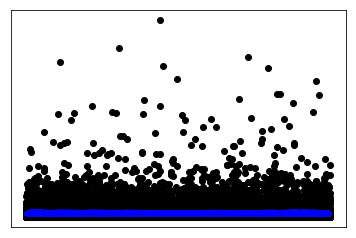

In [90]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_dtrain, y_dtrain)

# Make predictions using the testing set
y_pred = regr.predict(X_dvalid)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_dvalid, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_dvalid, y_pred))

# Plot outputs
plt.scatter(list(X_dvalid.index), y_dvalid,  color='black')
plt.plot(list(X_dvalid.index), y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

### RNN using pytorch

In [91]:
import torch
from torch.nn import functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

In [92]:
# Hyper parameters
TIME_STEP= 10            # rnn time step
INPUT_SIZE = 1           # rnn input size
LR = 0.02                # learning rate

In [93]:
X_dtrain.as_matrix().shape[0]

1408408

In [94]:
# show data
N = X_dtrain.as_matrix().shape[0]
steps = np.linspace(0, np.pi*2, N, dtype=np.float32)
x_np = X_dtrain.as_matrix().astype(np.float32)
y_np = y_dtrain.as_matrix().astype(np.float32)

In [95]:
class RNN(torch.nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        self.rnn = torch.nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=32,         # rnn hidden unit
            num_layers=1,             # number of rnn layer
            batch_first=True,         # input and output will have batch size as 1s dimension, e.g. (batch, time_step, input_size)
        )
        
        self.out = torch.nn.Linear(32, 1)
        
    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)
        
        outs = []    # save all predictions
        for time_step in range(r_out.size(1)):    # calculating output for each time step
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state
    
        # instead, for simplicity, you can replace above codes by follows
        # r_out = r_out.view(-1, 32)
        # outs = self.out(r_out)
        # return outs, h_state

In [96]:
rnn = RNN()
print(rnn)  # net architecture

RNN (
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear (32 -> 1)
)


In [97]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

In [98]:
h_state = None # for initial hidden state

for step in range(60):
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = X_dtrain.as_matrix().astype(np.float32)
    y_np = y_dtrain.as_matrix().astype(np.float32)
    
#     x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis]))    # shape (batch, time_step, input_size)
#     y = Variable(torch.from_numpy(y_np[np.newaxis, :, np.newaxis]))
    x = Variable(torch.from_numpy(x_np))    # shape (batch, time_step, input_size)
    y = Variable(torch.from_numpy(y_np))

    
    prediction, h_state = rnn(x, h_state) # rnn output
    # !! next step is important !!
    h_state = Variable(h_state.data)        # repack the hidden state, break the connection from last iteration
    
    loss = loss_func(prediction, y)         # cross entropy loss
    optimizer.zero_grad()                   # clear gradients for this training loss
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients

RuntimeError: size mismatch, m1: [1 x 1408408], m2: [1 x 32] at /opt/conda/conda-bld/pytorch_1503965122592/work/torch/lib/TH/generic/THTensorMath.c:1293

In [ ]:
from itertools import count

import torch
import torch.autograd
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
POLY_DEGREE = 3
W_target = torch.randn(POLY_DEGREE, 1) * 5
b_target = torch.randn(1) * 5

In [ ]:
W_target

In [ ]:
b_target

In [ ]:
def make_features(x):
    """Builds features i.e. a matrix with columns [x, x^2, x^3, x^4]."""
    x_np = X_dtrain.as_matrix().astype(np.float32)
    return torch.from_numpy(x_np)
#     return torch.cat([x ** i for i in range(1, POLY_DEGREE+1)], 1)

In [ ]:
def f(x):
    """Approximated function."""
    y_n = y_dtrain.as_matrix().astype(np.float32)
    return torch.from_numpy(y_np)

In [ ]:
def poly_desc(W, b):
    """Creates a string description of a polynomial."""
    result = 'y = '
    for i, w in enumerate(W):
        result += '{:+.2f} x^{} '.format(w, len(W) - i)
    result += '{:+.2f}'.format(b[0])
    return result

In [ ]:
def get_batch(batch_size=32):
    """Builds a batch i.e. (x, f(x)) pair."""
    random = torch.randn(batch_size)
    x = make_features(random)
    y = f(x)
    return Variable(x), Variable(y)

In [ ]:
# Define model
fc = torch.nn.Linear(W_target.size(0), 1)

for batch_idx in count(1):
# for batch_idx in range(1, 1000):
    # Get data
    batch_x, batch_y = get_batch()

    # Reset gradients
    fc.zero_grad()

    # Forward pass
    output = F.smooth_l1_loss(fc(batch_x), batch_y)
    loss = output.data[0]

    # Backward pass
    output.backward()

    # Apply gradients
    for param in fc.parameters():
        param.data.add_(-0.1 * param.grad.data)

    # Stop criterion
    if loss < 1e-3:
        break

print('Loss: {:.6f} after {} batches'.format(loss, batch_idx))
print('==> Learned function:\t' + poly_desc(fc.weight.data.view(-1), fc.bias.data))
print('==> Actual function:\t' + poly_desc(W_target.view(-1), b_target))

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)  # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)  # outut layer
        
    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)         
        # linear output
        return x

In [ ]:
net = Net(n_feature=3, n_hidden=10, n_output=1)     # define the network
print(net)  # net architecture

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

In [ ]:
for t in range(100):
    batch_x, batch_y = get_batch()
    prediction = net(batch_x)               # input x and predict based on x
    loss = loss_func(prediction, batch_y)   # must be (1. nn output, 2. target)
    optimizer.zero_grad()             # clear gradients for next train
    loss.backward()                   # backpropagation, compute gradients
    optimizer.step()                  # apply gradients
    
#     if t % 5 == 0:
#         # plot and show learning process
#         plt.cla()
#         plt.scatter(x.data.numpy(), y.data.numpy())
#         plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
#         plt.text(0.5, 0, 'Loss=%.4f' % loss.data[0], fontdict={'size': 20, 'color':  'red'})
#         plt.pause(0.1)

In [ ]:
# Make predictions using the testing set
prediction = prediction.data.numpy()
y_validation = batch_y.data.numpy()

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_validation, prediction))
# # Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % r2_score(y_dvalid, y_pred))

In [ ]:
y_validation = batch_y.data.numpy()

print('the score got from pytorch neural network is:')
print(rmsle(y_validation, prediction))

References:

https://www.kaggle.com/kswamy15/mercari-using-pytorch

http://scikit-learn.org/stable/modules/ensemble.html

In [ ]:
axes = plt.gca()
axes.set_ylim([0,100])
plt.scatter(predicted,y_dvalid)

In [ ]:
### Implement and save submission
x_test_1['price'] = reg.predict(x_test_1)
x_test_1['test_id'] = test_df['test_id']

print('Validation Data Distribution: \n', x_test_1['price'].value_counts(normalize = True))
submit.sample(10)

In [ ]:
#submit file
submit = x_test_1[['test_id','price']]
submit.to_csv("data/mercari/sample_submission.csv", index=False)

References:

https://www.kaggle.com/kswamy15/mercari-using-pytorch

http://scikit-learn.org/stable/modules/ensemble.html